In [0]:
# !wget http://www.robots.ox.ac.uk/~vgg/research/counting/cells.zip
# !mkdir synthetic_cells
# !unzip cell.zip -d synthetic_cells


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**prepare cytology dataset**

In [0]:
! cp ./drive/My\ Drive/cervix_data.zip ./
!pwd

/content


In [0]:
!mkdir cells
!unzip cervix_data.zip -d ./cells/
!ls ./cells/

# ./cells/cervix_images   => images
# ./cells/cervix_labels   => lebls / mask images

In [1]:
import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
# from six.moves import range
import os
import threading
import matplotlib.pyplot as plt
from keras import backend as K
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import (
    Input,
    Activation,
    merge,
    Dropout,
    Reshape,
    Permute,
    Dense,
    UpSampling2D,
    Flatten
    )
from keras.optimizers import SGD, RMSprop
from keras.layers.merge import concatenate as Concatenate
from keras.layers.convolutional import (
    Convolution2D)
from keras.layers.pooling import (
    MaxPooling2D,
    AveragePooling2D
    )
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import numpy as np
import pdb
import os
import matplotlib.pyplot as plt
# from generator import ImageDataGenerator
# from model import buildModel_U_net
from keras import backend as K
from keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler
from scipy import misc
import scipy.ndimage as ndimage

from skimage import io


def show(image):
  io.imshow(image)
  io.show()

Using TensorFlow backend.


In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 27 19:16:49 2017

@author: Weidi Xie

@description:
This is used for augmentation on-the-fly.
"""
import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
# from six.moves import range
import os
import threading
import matplotlib.pyplot as plt
from keras import backend as K


def random_channel_shift(x, intensity, channel_index=0):
    x = np.rollaxis(x, channel_index, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x, transform_matrix, channel_index=0, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, dim_ordering='default', scale=True):
    from PIL import Image
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    if dim_ordering == 'th':
        x = x.transpose(1, 2, 0)
    if scale:
        x += max(-np.min(x), 0)
        x /= np.max(x)
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return Image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return Image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise Exception('Unsupported channel number: ', x.shape[2])


def img_to_array(img, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    if dim_ordering not in ['th', 'tf']:
        raise Exception('Unknown dim_ordering: ', dim_ordering)
    # image has dim_ordering (height, width, channel)
    x = np.asarray(img, dtype='float32')
    if len(x.shape) == 3:
        if dim_ordering == 'th':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if dim_ordering == 'th':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise Exception('Unsupported image shape: ', x.shape)
    return x


class ImageDataGenerator(object):
    '''Generate minibatches with
    real-time data augmentation.
    Assume X is train img, Y is train label (same size as X with only 0 and 255 for values)
    # Arguments
        featurewise_center: set input mean to 0 over the dataset. Only to X
        samplewise_center: set each sample mean to 0. Only to X
        featurewise_std_normalization: divide inputs by std of the dataset. Only to X
        samplewise_std_normalization: divide each input by its std. Only to X
        zca_whitening: apply ZCA whitening. Only to X
        rotation_range: degrees (0 to 180). To X and Y
        width_shift_range: fraction of total width. To X and Y
        height_shift_range: fraction of total height. To X and Y
        shear_range: shear intensity (shear angle in radians). To X and Y
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range. To X and Y
        channel_shift_range: shift range for each channels. Only to X
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'. For Y, always fill with constant 0
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally. To X and Y
        vertical_flip: whether to randomly flip images vertically. To X and Y
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided (before applying
            any other transformation). Only to X
        dim_ordering: 'th' or 'tf'. In 'th' mode, the channels dimension
            (the depth) is at index 1, in 'tf' mode it is at index 3.
            It defaults to the `image_dim_ordering` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "th".
    '''
    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 dim_ordering='default'):
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        self.__dict__.update(locals())
        self.mean = None
        self.std = None
        self.principal_components = None
        self.rescale = rescale

        if dim_ordering not in {'tf', 'th'}:
            raise Exception('dim_ordering should be "tf" (channel after row and '
                            'column) or "th" (channel before row and column). '
                            'Received arg: ', dim_ordering)
        self.dim_ordering = dim_ordering
        if dim_ordering == 'th':
            self.channel_index = 1
            self.row_index = 2
            self.col_index = 3
        if dim_ordering == 'tf':
            self.channel_index = 3
            self.row_index = 1
            self.col_index = 2

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise Exception('zoom_range should be a float or '
                            'a tuple or list of two floats. '
                            'Received arg: ', zoom_range)

    def flow(self, X, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            dim_ordering=self.dim_ordering,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)

    def standardize(self, x):
        # Only applied to X
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_index = self.channel_index - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_index, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_index, keepdims=True) + 1e-7)

        if self.featurewise_center:
            x -= self.mean
        if self.featurewise_std_normalization:
            x /= (self.std + 1e-7)

        if self.zca_whitening:
            flatx = np.reshape(x, (x.size))
            whitex = np.dot(flatx, self.principal_components)
            x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))

        return x

    def random_transform(self, x, y):
        # Need to modify to transform both X and Y ---- to do
        # x is a single image, so it doesn't have image number at index 0
        img_row_index = self.row_index - 1
        img_col_index = self.col_index - 1
        img_channel_index = self.channel_index - 1

        # use composition of homographies to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_index]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_index]
        else:
            ty = 0

        translation_matrix = np.array([[1, 0, tx],
                                       [0, 1, ty],
                                       [0, 0, 1]])
        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)
        zoom_matrix = np.array([[zx, 0, 0],
                                [0, zy, 0],
                                [0, 0, 1]])

        transform_matrix = np.dot(np.dot(np.dot(rotation_matrix, translation_matrix), shear_matrix), zoom_matrix)

        h, w = x.shape[img_row_index], x.shape[img_col_index]
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        x = apply_transform(x, transform_matrix, img_channel_index,
                            fill_mode=self.fill_mode, cval=self.cval)
        # For y, mask data, fill mode constant, cval = 0
        y = apply_transform(y, transform_matrix, img_channel_index,
                            fill_mode=self.fill_mode, cval= self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x, self.channel_shift_range, img_channel_index)

        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_index)
                y = flip_axis(y, img_col_index)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_index)
                y = flip_axis(y, img_row_index)

        # TODO:
        # channel-wise normalization
        # barrel/fisheye
        return x, y

    def fit(self, X,
            augment=False,
            rounds=1,
            seed=None):
        '''Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
        # Arguments
            X: Numpy array, the data to fit on.
            augment: whether to fit on randomly augmented samples
            rounds: if `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        # Only applied to X
        '''
        X = np.copy(X)
        if augment:
            aX = np.zeros(tuple([rounds * X.shape[0]] + list(X.shape)[1:]))
            for r in range(rounds):
                for i in range(X.shape[0]):
                    aX[i + r * X.shape[0]] = self.random_transform(X[i])
            X = aX

        if self.featurewise_center:
            self.mean = np.mean(X, axis=0)
            X -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(X, axis=0)
            X /= (self.std + 1e-7)

        if self.zca_whitening:
            flatX = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))
            sigma = np.dot(flatX.T, flatX) / flatX.shape[1]
            U, S, V = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(U, np.diag(1. / np.sqrt(S + 10e-7))), U.T)


class Iterator(object):

    def __init__(self, N, batch_size, shuffle, seed):
        self.N = N
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(N, batch_size, shuffle, seed)

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, N, batch_size=32, shuffle=False, seed=None):
        # ensure self.batch_index is 0
        self.reset()
        while 1:
            if self.batch_index == 0:
                index_array = np.arange(N)
                if shuffle:
                    if seed is not None:
                        np.random.seed(seed + self.total_batches_seen)
                    index_array = np.random.permutation(N)

            current_index = (self.batch_index * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = N - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        # ?
        return self.next(*args, **kwargs)


class NumpyArrayIterator(Iterator):

    def __init__(self, X, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 dim_ordering='default',
                 save_to_dir=None, save_prefix='', save_format='jpeg'):
        if len(X) != len(y):
            raise Exception('X (images tensor) and y (labels) '
                            'should have the same length. '
                            'Found: X.shape = %s, y.shape = %s' % (np.asarray(X).shape, np.asarray(y).shape))
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        self.X = X
        self.y = y
        self.image_data_generator = image_data_generator
        self.dim_ordering = dim_ordering
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(X.shape[0], batch_size, shuffle, seed)

    def next(self):
        # for python 2.x.
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.X.shape)[1:]))
        batch_y = np.zeros(tuple([current_batch_size] + list(self.y.shape)[1:]))
        for i, j in enumerate(index_array):
            x = self.X[j]
            label = self.y[j]
            x, label = self.image_data_generator.random_transform(x.astype('float32'), label.astype('float32'))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_y[i] = label
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
                mask = array_to_img(batch_y[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}_mask.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                mask.save(os.path.join(self.save_to_dir, fname))
        return batch_x, batch_y




In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 27 19:13:36 2017

@author: Weidi Xie

@description: 
This is the file to create the model, similar as the paper, 
but with batch normalization,
make it more easier to train.

U-net version is also provided.
"""

from __future__ import absolute_import
from __future__ import print_function
import numpy as np
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import (
    Input,
    Activation,
    merge,
    Dropout,
    Reshape,
    Permute,
    Dense,
    UpSampling2D,
    Flatten
    )
from keras.optimizers import SGD, RMSprop
from keras.layers.merge import concatenate as Concatenate
from keras.layers.convolutional import (
    Convolution2D)
from keras.layers.pooling import (
    MaxPooling2D,
    AveragePooling2D
    )
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

weight_decay = 1e-5
K.set_image_dim_ordering('tf')

def _conv_bn_relu(nb_filter, row, col, subsample = (1,1)):
    def f(input):
        conv_a = Convolution2D(nb_filter, row, col, subsample = subsample,
                               init = 'orthogonal', 
                               border_mode='same', bias = False)(input)
        norm_a = BatchNormalization()(conv_a)
        act_a = Activation(activation = 'relu')(norm_a)
        return act_a
    return f
    
def _conv_bn_relu_x2(nb_filter, row, col, subsample = (1,1)):
    def f(input):
        conv_a = Convolution2D(nb_filter, row, col, subsample = subsample,
                               init = 'orthogonal', border_mode = 'same',bias = False,
                               W_regularizer = l2(weight_decay),
                               b_regularizer = l2(weight_decay))(input)
        norm_a = BatchNormalization()(conv_a)
        act_a = Activation(activation = 'relu')(norm_a)
        conv_b = Convolution2D(nb_filter, row, col, subsample = subsample,
                               init = 'orthogonal', border_mode = 'same',bias = False,
                               W_regularizer = l2(weight_decay),
                               b_regularizer = l2(weight_decay))(act_a)
        norm_b = BatchNormalization()(conv_b)
        act_b = Activation(activation = 'relu')(norm_b)
        return act_b
    return f

def FCRN_A_base(input):
    block1 = _conv_bn_relu(32,3,3)(input)
    pool1 = MaxPooling2D(pool_size=(2,2))(block1)
    # =========================================================================
    block2 = _conv_bn_relu(64,3,3)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(block2)
    # =========================================================================
    block3 = _conv_bn_relu(128,3,3)(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(block3)
    # =========================================================================
    block4 = _conv_bn_relu(512,3,3)(pool3)
    # =========================================================================
    up5 = UpSampling2D(size=(2, 2))(block4)
    block5 = _conv_bn_relu(128,3,3)(up5)
    # =========================================================================
    up6 = UpSampling2D(size=(2, 2))(block5)
    block6 = _conv_bn_relu(64,3,3)(up6)
    # =========================================================================
    up7 = UpSampling2D(size=(2, 2))(block6)
    block7 = _conv_bn_relu(32,3,3)(up7)
    return block7

def FCRN_A_base_v2(input):
    block1 = _conv_bn_relu_x2(32,3,3)(input)
    pool1 = MaxPooling2D(pool_size=(2,2))(block1)
    # =========================================================================
    block2 = _conv_bn_relu_x2(64,3,3)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(block2)
    # =========================================================================
    block3 = _conv_bn_relu_x2(128,3,3)(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(block3)
    # =========================================================================
    block4 = _conv_bn_relu(512,3,3)(pool3)
    # =========================================================================
    up5 = UpSampling2D(size=(2, 2))(block4)
    block5 = _conv_bn_relu_x2(128,3,3)(up5)
    # =========================================================================
    up6 = UpSampling2D(size=(2, 2))(block5)
    block6 = _conv_bn_relu_x2(64,3,3)(up6)
    # =========================================================================
    up7 = UpSampling2D(size=(2, 2))(block6)
    block7 = _conv_bn_relu_x2(32,3,3)(up7)
    return block7

def U_net_base(input, nb_filter = 64):
    block1 = _conv_bn_relu_x2(nb_filter,3,3)(input)
    pool1 = MaxPooling2D(pool_size=(2,2))(block1)
    # =========================================================================
    block2 = _conv_bn_relu_x2(nb_filter,3,3)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(block2)
    # =========================================================================
    block3 = _conv_bn_relu_x2(nb_filter,3,3)(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(block3)
    # =========================================================================
    block4 = _conv_bn_relu_x2(nb_filter,3,3)(pool3)
    up4 = Concatenate([UpSampling2D(size=(2, 2))(block4), block3], axis=-1)
    # =========================================================================
    block5 = _conv_bn_relu_x2(nb_filter,3,3)(up4)
    up5 = Concatenate([UpSampling2D(size=(2, 2))(block5), block2], axis=-1)
    # =========================================================================
    block6 = _conv_bn_relu_x2(nb_filter,3,3)(up5)
    up6 = Concatenate([UpSampling2D(size=(2, 2))(block6), block1], axis=-1)
    # =========================================================================
    block7 = _conv_bn_relu(nb_filter,3,3)(up6)
    return block7

def buildModel_FCRN_A (input_dim):
    input_ = Input (shape = (input_dim))
    # =========================================================================
    act_ = FCRN_A_base (input_)
    # =========================================================================
    density_pred =  Convolution2D(1, 1, 1, bias = False, activation='linear',\
                                  init='orthogonal',name='pred',border_mode='same')(act_)
    # =========================================================================
    model = Model (input = input_, output = density_pred)
    opt = SGD(lr = 1e-2, momentum = 0.9, nesterov = True)
    model.compile(optimizer = opt, loss = 'mse')
    return model

def buildModel_FCRN_A_v2 (input_dim):
    input_ = Input (shape = (input_dim))
    # =========================================================================
    act_ = FCRN_A_base_v2 (input_)
    # =========================================================================
    density_pred =  Convolution2D(1, 1, 1, bias = False, activation='linear',\
                                  init='orthogonal',name='pred',border_mode='same')(act_)
    # =========================================================================
    model = Model (input = input_, output = density_pred)
    opt = SGD(lr = 1e-2, momentum = 0.9, nesterov = True)
    model.compile(optimizer = opt, loss = 'mse')
    return model

def buildModel_U_net (input_dim):
    input_ = Input (shape = (input_dim))
    # =========================================================================
    act_ = U_net_base (input_, nb_filter = 64 )
    # =========================================================================
    density_pred =  Convolution2D(1, 1, 1, bias = False, activation='linear',\
                                  init='orthogonal',name='pred',border_mode='same')(act_)
    # =========================================================================
    model = Model (input = input_, output = density_pred)
    opt = RMSprop(1e-3)
    model.compile(optimizer = opt, loss = 'mse')
    return model


In [0]:
base_path = './cells/cervix_images/'
labels_path = './cells/cervix_labels/'

def read_data(base_path, labels_path):
  data = []
  anno = []
  imList = sorted(os.listdir(base_path))
  imList = imList[-840:]
  for img in imList:
        img1 = misc.imread(os.path.join(base_path,img))
        # img1 = np.dstack((img1, img1, img1))
        data.append(img1)
        img2 = misc.imread(os.path.join(labels_path, img))
        # img2 = ndimage.gaussian_filter(img2, sigma=(1, 1), order=0)
        img2 = img2
        anno.append(img2)
  #return data[0], anno[0], imList
  return np.asarray(data), np.asarray(anno), imList


#data, anno, imList = read_data(base_path, labels_path)

In [0]:
from skimage.morphology import square, closing, binary_closing, label
from skimage import filters, morphology, measure, feature
from sklearn.metrics import mean_squared_error
import math

In [6]:
data  = []
anno = []
base_path = './cells/cervix_images/'
labels_path = './cells/cervix_labels/'
data, anno, imList = read_data(base_path, labels_path)
anno = np.expand_dims(anno, axis = -1)
test_data = data
test_anno = anno
del data
del anno

# Load counts for cells for test_set
ground_truth_count = []
for filename in imList:
  with open('./cells/cervix_nuclei_count/' + filename[:-3] + 'txt') as file:
    text = file.read()
    count = int(text)
  ground_truth_count.append(count)
len(ground_truth_count)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]


840

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 27 19:12:53 2017

@author: Weidi Xie

@Description: This is the file used for training, loading images, annotation, training with model.
"""

import numpy as np
import pdb
import os
import matplotlib.pyplot as plt
# from generator import ImageDataGenerator
# from model import buildModel_U_net
from keras import backend as K
from keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler
from scipy import misc
import scipy.ndimage as ndimage

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# base_path = './cells/'
data = []
anno = []

def step_decay(epoch):
    step = 16
    num =  epoch // step 
    if num % 3 == 0:
        lrate = 1e-3
    elif num % 3 == 1:
        lrate = 1e-4
    else:
        lrate = 1e-5
      # lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
    return np.float(lrate)
  

def train_(base_path):
    base_path = './cells/cervix_images/'
    labels_path = './cells/cervix_labels/'
    data, anno, imList = read_data(base_path, labels_path)
    anno = np.expand_dims(anno, axis = -1)
    
    #mean = np.mean(data)
    #std = np.std(data)
    
    #data_ = (data - mean) / std
    
    data_len = len(data)
    train_split = int(data_len*0.7)
    val_split = int(data_len*0.2)
    test_split = int(data_len*0.1)
    
    train_data = data[:train_split]
    train_anno = anno[:train_split]
    val_data = data[train_split : train_split+val_split]
    val_anno = anno[train_split : train_split+val_split]
    
    del data
    del anno
    
    print('-'*30)
    print('Creating and compiling the fully convolutional regression networks.')
    print('-'*30)
    
    model = buildModel_U_net(input_dim = (224,224, 3))
    model_checkpoint = ModelCheckpoint('cell_counting.hdf5', monitor='loss', save_best_only=True)
    model.summary()
    print('...Fitting model...')
    print('-'*30)
    change_lr = LearningRateScheduler(step_decay)

    datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
        zoom_range = 0.3,
        shear_range = 0.,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True, # randomly flip images
        fill_mode = 'constant',
        dim_ordering = 'tf')  

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(train_data,
                                     train_anno,
                                     batch_size = 16
                                     ),
                        samples_per_epoch = train_data.shape[0],
                        nb_epoch = 50,
                        callbacks = [model_checkpoint, change_lr],
                        verbose = 1, 
                        validation_data = (val_data, val_anno)
                       )
    
    model.load_weights('cell_counting.hdf5')
    A = model.predict(val_data)
    mean_diff = np.average(np.abs(np.sum(np.sum(A,1),1)-np.sum(np.sum(val_anno,1),1))) / (100.0)
    print('After training, the difference is : {} cells per image.'.format(np.abs(mean_diff)))
    # save the model
    model.save("cell_counting_model_v_2.hdf5")    
    return model


model = train_(base_path)


In [10]:
test_data.shape

(840, 224, 224, 3)

In [8]:
A = model.predict(test_data)
mean_diff = np.average(np.abs(np.sum(np.sum(A,1),1)-np.sum(np.sum(test_anno,1),1))) / (100.0)
print('After training TEST SCORE, the difference is : {} cells per image.'.format(np.abs(mean_diff)))

After training TEST SCORE, the difference is : 2.4689808753899167 cells per image.


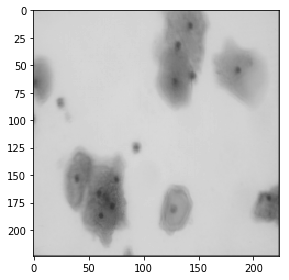

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


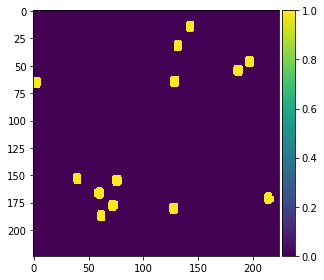

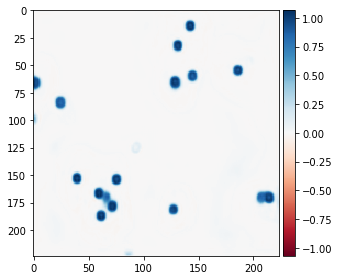

13  Cells


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


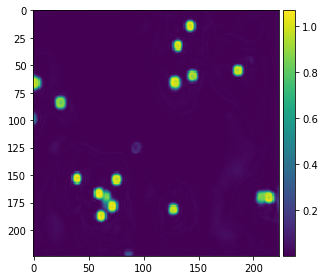

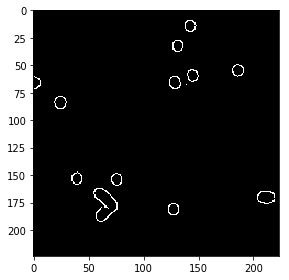

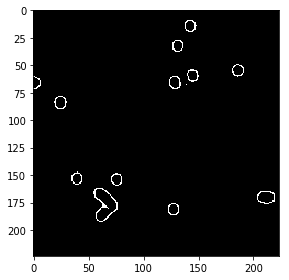

13


In [9]:
sample = 0

show(test_data[sample, :, :, 0])
show(test_anno[sample, :, :, 0])
show(A[sample, :, :, 0])
print(ground_truth_count[sample], ' Cells')


# =========================

output = A[sample, :, :, 0]
# show(A[sample, :, :, 0])


absolute_output = np.abs(output)
show(absolute_output)

# laplase, sobel, otsu, sauvola  etdge detection

canny_output = feature.canny(absolute_output, sigma=4)
show(canny_output)

closed_output = morphology.binary_closing(canny_output, selem=np.ones((3,3)))
show(closed_output)

labeled_output = measure.label(canny_output)
# show(labeled_output)


print(len(np.unique(labeled_output)) - 1)

# =========================


In [0]:
np.save("pred_img.npy", output)

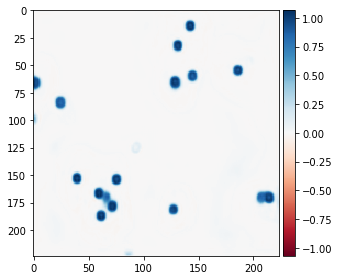

In [0]:
# img = np.load("pred_img.npy")
show(img)

In [0]:
def count_cells(input_img, sigma=4):
  absolute_output = np.abs(input_img)
  canny_output = feature.canny(absolute_output, sigma=sigma)
  closed_output = morphology.binary_closing(canny_output, selem=np.ones((3,3)))
  labeled_output = measure.label(canny_output)
  count = len(np.unique(labeled_output)) - 1
  return count


In [0]:
y_pred = model.predict(test_data)
for sigma in [4, 4.3, 4.5, 4.7, 5, 5.3, 5.5, 5.7, 5.9, 6]:
  test_cell_count = [count_cells(sample_img[:,:,0], sigma) for sample_img in y_pred]
  mse = mean_squared_error(test_cell_count, ground_truth_count)
  print("sigma={} , root_mean_squared_error= {}".format(sigma, math.sqrt(mse)))

sigma=4 , root_mean_squared_error= 3.5790395093549625
sigma=4.3 , root_mean_squared_error= 3.448947389456397
sigma=4.5 , root_mean_squared_error= 3.3042180834286867
sigma=4.7 , root_mean_squared_error= 3.102993945945017
sigma=5 , root_mean_squared_error= 2.9319666729737177
sigma=5.3 , root_mean_squared_error= 2.927903524301825
sigma=5.5 , root_mean_squared_error= 2.969487690302343
sigma=5.7 , root_mean_squared_error= 3.367562351386562
sigma=5.9 , root_mean_squared_error= 3.9980650081663014
sigma=6 , root_mean_squared_error= 4.548678510345196


In [0]:
# Check Score for Segmentation Model

def get_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


mask_images = test_anno[:, :, :, 0]
threshold = 0.3
scores = []
for index in range(len(A)):
  image = np.abs( A[index,:,:, 0] > threshold )
  mask = mask_images[index]
  iou_score = get_iou_score(image, mask)
  if iou_score == iou_score:
    scores.append(iou_score)
print("mean score with threshold = {}  is: {}".format(threshold, np.mean(np.asarray(scores))))


mean score with threshold = 0.3  is: 0.5571720622299654


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [0]:
# # uncomment for testing different thresholds


# mask_images = test_anno[:, :, :, 0]
# for th in range(1, 10):
#   threshold = th/10
#   thresholded_predictions = A[:,:,:,0] > threshold
#   scores = []
#   for index in range(len(thresholded_predictions)):
#     image = thresholded_predictions[index]
#     mask = mask_images[index]
#     iou_score = get_iou_score(image, mask)
#     if iou_score == iou_score:
#       scores.append(iou_score)
#   print("mean score with threshold = {}  is: {}".format(threshold, np.mean(np.asarray(scores))))


In [0]:
np.argwhere(np.isnan(scores))
# show(thresholded_predictions[196])

# show(mask_images[196])



array([], shape=(0, 1), dtype=int64)

In [0]:
from google.colab import files
files.download('cell_counting_model_v_2.hdf5')

In [0]:
from google.colab import files
files.upload()

In [0]:
from keras.models import load_model
model = load_model("cell_counting_model_v_2.hdf5")

In [0]:
from google.colab import files
# files.download('pred_img.npy')

**Segmentation Test on Random Samples**

In [0]:
# A = model.predict(test_data)
# test_data.shape
model.evaluate(test_data, test_anno)

A.shape, test_anno.shape

((840, 224, 224, 1), (840, 224, 224, 1))

In [0]:
import random
x = [random.randint(x,840) for x in range(10) ]
len(set(x))

10

In [0]:
np.save("test_data_array.npy", test_data)
np.save("test_annotations_array.npy", test_anno)
np.save("predictions_array.npy", A)

In [0]:
files.download('test_data_array.npy')
files.download('test_annotations_array.npy')
files.download('predictions_array.npy')

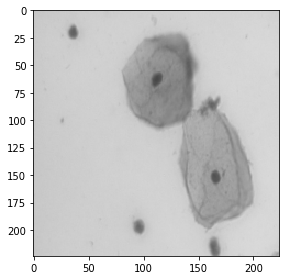

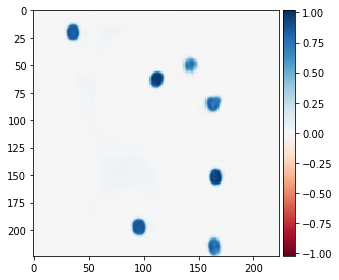

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


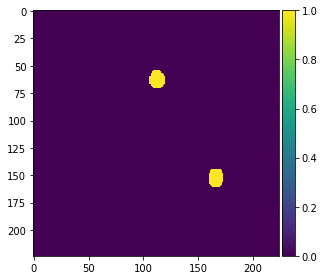

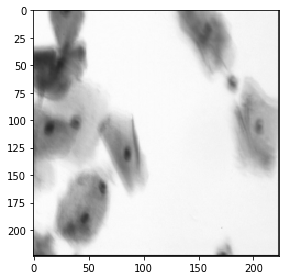

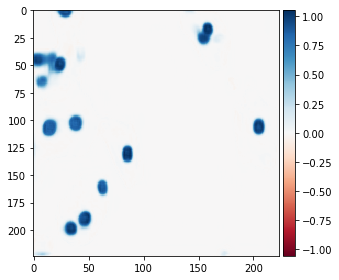

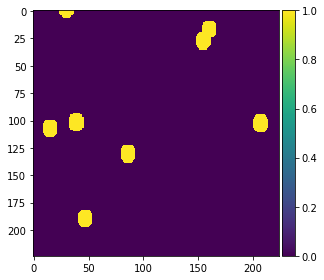

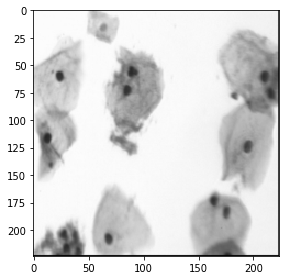

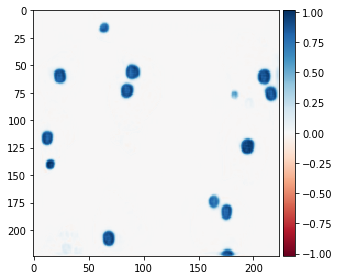

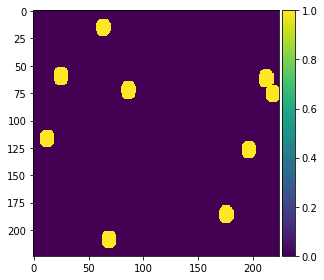

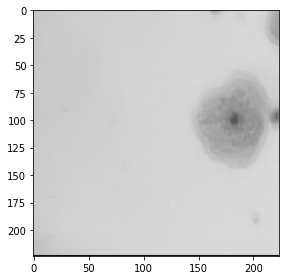

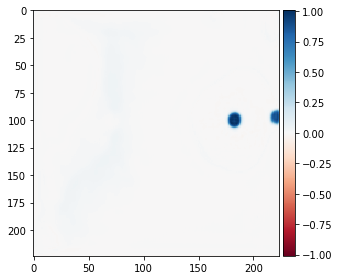

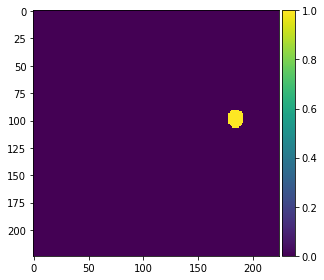

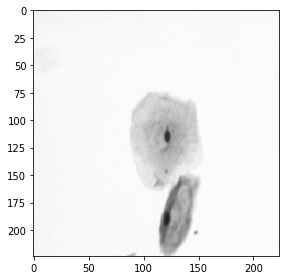

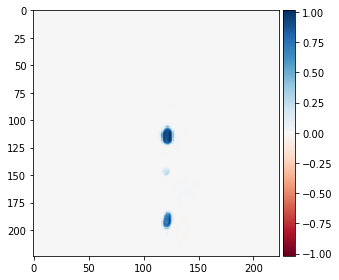

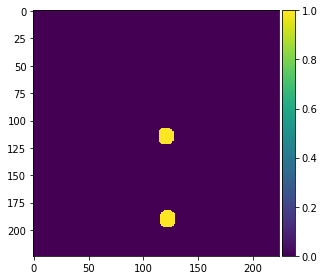

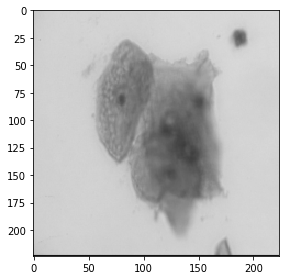

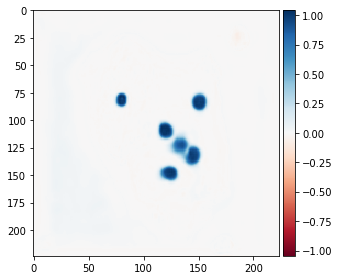

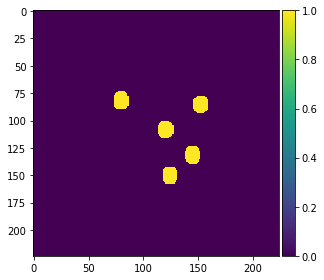

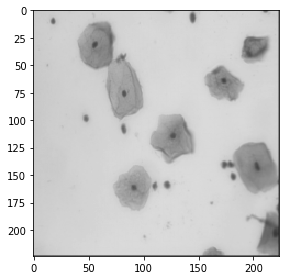

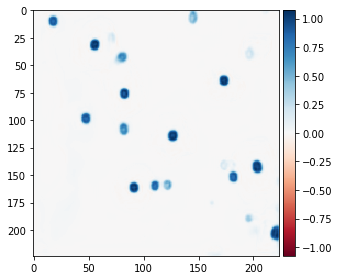

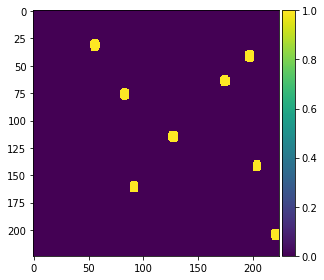

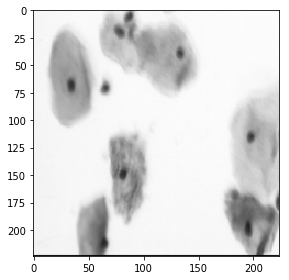

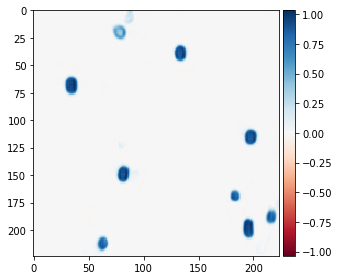

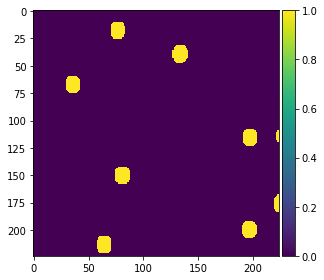

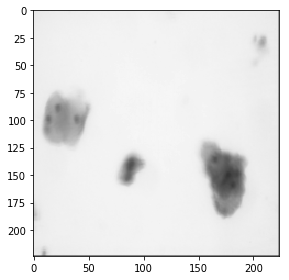

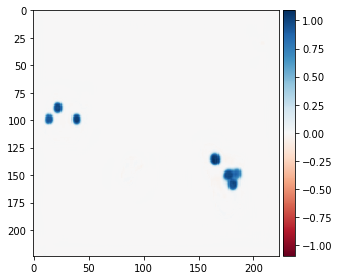

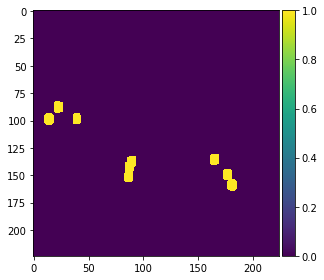

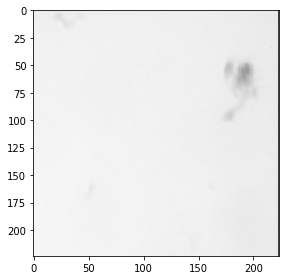

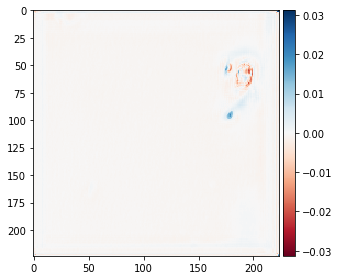

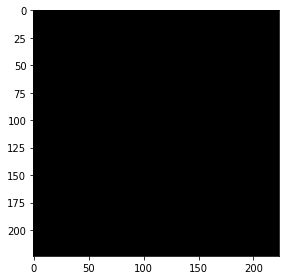

In [0]:
for index in x:
  show(test_data[index,:,:,:])
  show(A[index,:, :, 0])
  show(test_anno[index,:,:,0])
  print("="*50)